In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import mne
mne.set_log_level('error')  # suppress mne warnings
from scipy.signal import stft
import pywt
from PyEMD import EMD

In [3]:
def generate_sinusoidal_signal(frequency=4, duration=3, sampling_rate=1000):
    """
    Generate a sinusoidal signal.

    Args:
        frequency (float): Frequency of the sine wave in Hz.
        duration (float): Duration of the signal in seconds.
        sampling_rate (int): Number of samples per second.

    Returns:
        t (np.ndarray): Time vector.
        signal (np.ndarray): Sinusoidal signal.
    """
    t = np.linspace(0, duration, int(sampling_rate * duration), endpoint=False)
    signal = np.sin(2 * np.pi * frequency * t)
    return t, signal

def generate_windowed_sinusoidal(frequency=12, duration=3, sampling_rate=1000, start=1, end=2):
    """
    Generate a sinusoidal signal with given frequency between 'start' and 'end' seconds, zero elsewhere.

    Args:
        frequency (float): Frequency of the sine wave in Hz.
        duration (float): Total duration of the signal in seconds.
        sampling_rate (int): Number of samples per second.
        start (float): Start time of the sinusoidal part in seconds.
        end (float): End time of the sinusoidal part in seconds.

    Returns:
        t (np.ndarray): Time vector.
        signal (np.ndarray): Windowed sinusoidal signal.
    """
    t = np.linspace(0, duration, int(sampling_rate * duration), endpoint=False)
    signal = np.zeros_like(t)
    mask = (t >= start) & (t < end)
    signal[mask] = np.sin(2 * np.pi * frequency * t[mask])
    return t, signal

def generate_chirp_signal(f0=30, f1=0, duration=3, sampling_rate=1000):
    """
    Generate a linear chirp signal.

    Args:
        f0 (float): Starting frequency of the chirp in Hz.
        f1 (float): Ending frequency of the chirp in Hz.
        duration (float): Duration of the signal in seconds.
        sampling_rate (int): Number of samples per second.

    Returns:
        t (np.ndarray): Time vector.
        signal (np.ndarray): Chirp signal.
    """
    t = np.linspace(0, duration, int(sampling_rate * duration), endpoint=False)
    k = (f1 - f0) / duration  # Chirp rate
    signal = np.sin(2 * np.pi * (f0 * t + 0.5 * k * t**2))
    return signal

# Example usage and plot
#if __name__ == "__main__":
t, signal1 = generate_sinusoidal_signal(frequency=4, duration=3, sampling_rate=1000)
t, signal2 = generate_sinusoidal_signal(18, 3, 1000)
t, signal3 = generate_windowed_sinusoidal(12, 3, 1000, 1, 2)
t, signal4 = generate_windowed_sinusoidal(15, 3, 1000, 1, 2)

mother_signal = signal1 + signal2 + signal3 + signal4

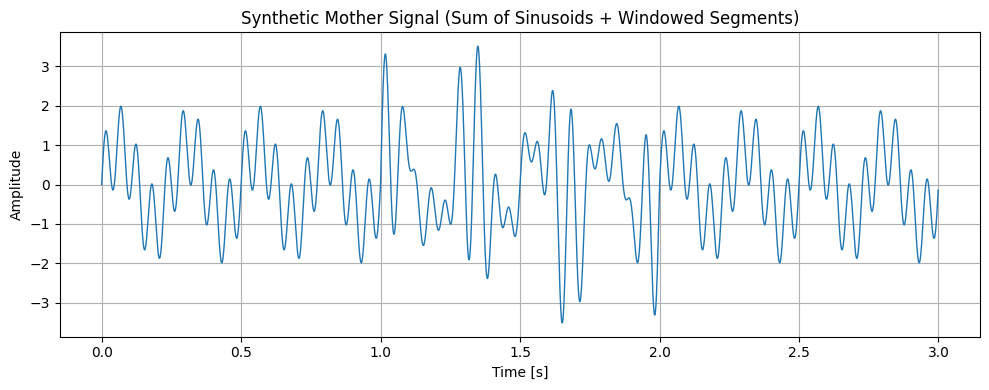

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(t, mother_signal, linewidth=1)
plt.title("Synthetic Mother Signal (Sum of Sinusoids + Windowed Segments)")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.grid(True)
plt.tight_layout()
plt.show()

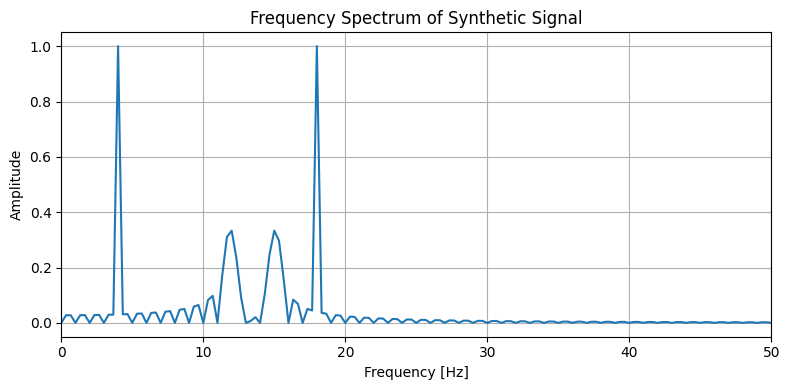

In [5]:
from scipy.fft import fft, fftfreq

# FFT parameters
N = len(mother_signal)
T = 1 / 1000  # sampling interval (1 / sampling_rate)

# Compute FFT
fft_values = fft(mother_signal)
fft_magnitude = 2.0 / N * np.abs(fft_values[:N // 2])
frequencies = fftfreq(N, T)[:N // 2]

# Plot the spectrum
plt.figure(figsize=(8, 4))
plt.plot(frequencies, fft_magnitude)
plt.title("Frequency Spectrum of Synthetic Signal")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Amplitude")
plt.xlim(0, 50)
plt.grid(True)
plt.tight_layout()
plt.show()


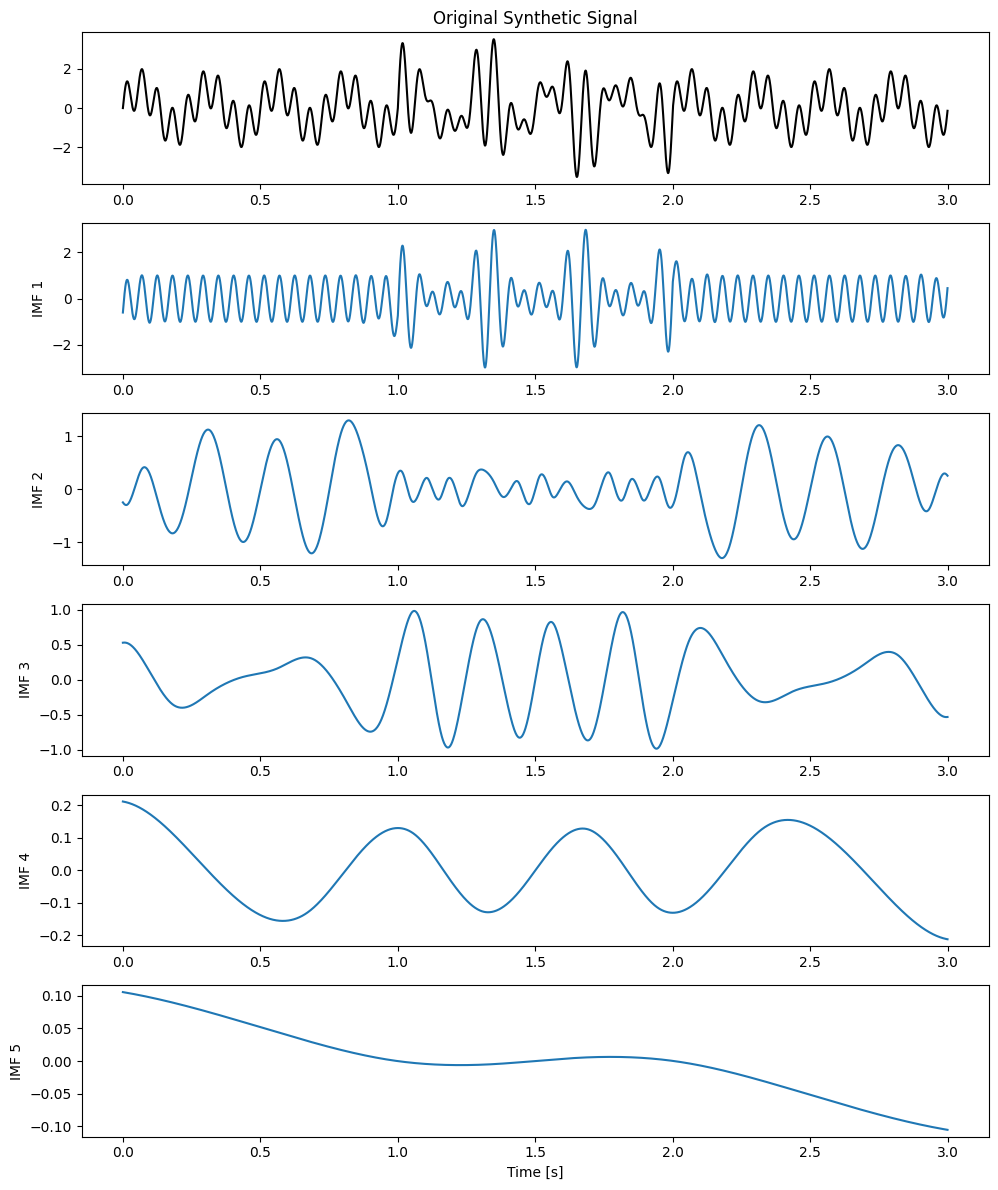

In [6]:


# Perform EMD decomposition
emd = EMD()
IMFs = emd.emd(mother_signal)
n_imfs = IMFs.shape[0]

# Plot IMFs
plt.figure(figsize=(10, 2 * (n_imfs + 1)))

plt.subplot(n_imfs + 1, 1, 1)
plt.plot(t, mother_signal, 'k')
plt.title("Original Synthetic Signal")

for i in range(n_imfs):
    plt.subplot(n_imfs + 1, 1, i + 2)
    plt.plot(t, IMFs[i])
    plt.ylabel(f"IMF {i+1}")
    if i == n_imfs - 1:
        plt.xlabel("Time [s]")

plt.tight_layout()
plt.show()


Extracted 5 IMFs using spline='hermite'


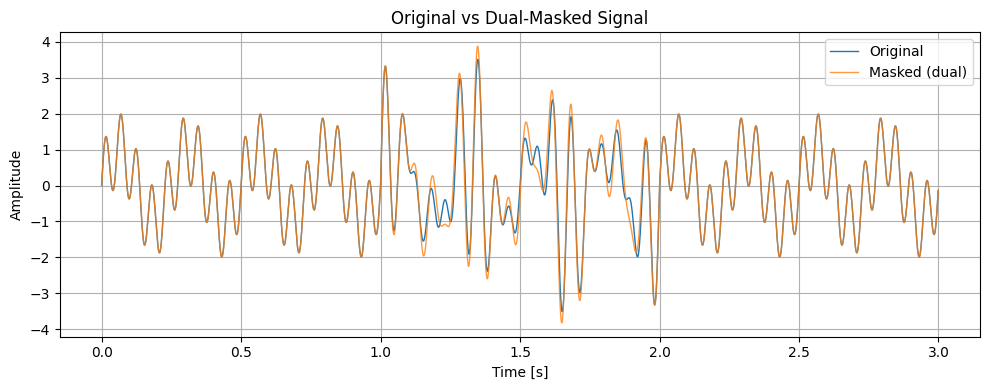

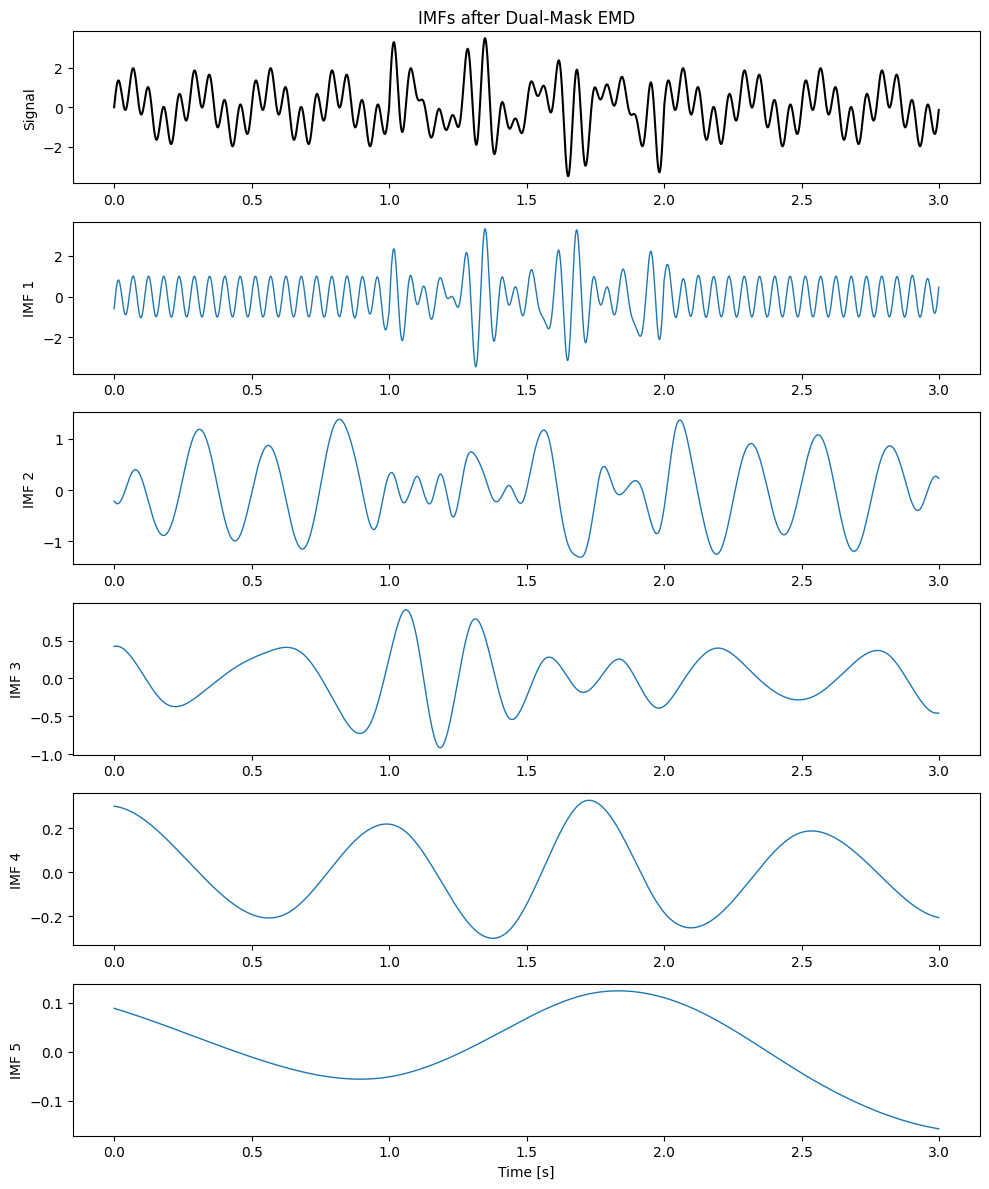

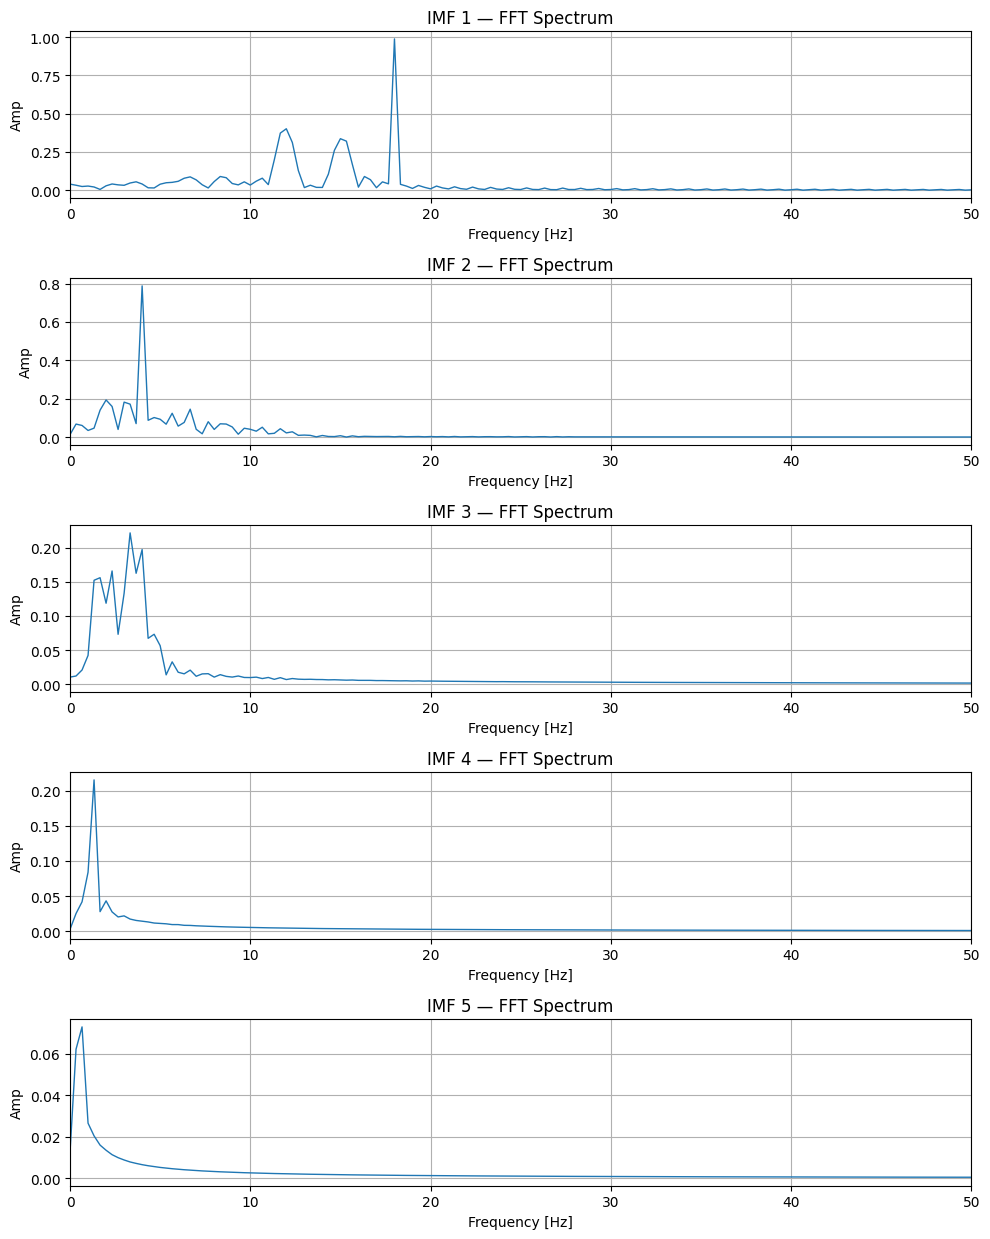

In [15]:
from scipy.signal.windows import tukey



# ===== PARAMETERS =====
fs = 1000.0           # sampling rate [Hz]
duration = 3.0         # seconds
# masks
mask_params = [
    {"freq": 12.0, "amp": 0.3, "phase": 0.0},   # first mask
    {"freq": 15.0, "amp": 0.3, "phase": np.pi/2} # second mask
]
window_start, window_end = 1.0, 2.0
tukey_alpha = 0.2      # taper
# EMD options
SPLINE = 'hermite'
SD = 0.2
MAX_ITER = 1000

# ===== TIME VECTOR =====
t = np.linspace(0, duration, int(fs * duration), endpoint=False)

# ===== BUILD WINDOW FUNCTION =====
w = np.zeros_like(t)
mask_idx = (t >= window_start) & (t <= window_end)
if np.any(mask_idx):
    L = mask_idx.sum()
    w_segment = tukey(L, tukey_alpha)
    w[mask_idx] = w_segment

# ===== BUILD COMBINED MASK =====
mask = np.zeros_like(t)
sig_rms = np.sqrt(np.mean(mother_signal**2))
for mp in mask_params:
    mask += (mp["amp"] * sig_rms) * np.sin(2*np.pi*mp["freq"]*t + mp["phase"]) * w

# ===== ADD MASK TO SIGNAL =====
masked_signal = mother_signal + mask

# ===== RUN EMD =====
emd = EMD()
emd.SplineKind = SPLINE
emd.SD = SD
emd.MAX_ITERATION = MAX_ITER
IMFs = emd.emd(masked_signal)
n_imfs = IMFs.shape[0]
print(f"Extracted {n_imfs} IMFs using spline='{SPLINE}'")

# ===== PLOTS: original vs masked =====
plt.figure(figsize=(10,4))
plt.plot(t, mother_signal, label="Original", linewidth=1)
plt.plot(t, masked_signal, label="Masked (dual)", linewidth=1, alpha=0.8)
plt.title("Original vs Dual-Masked Signal")
plt.xlabel("Time [s]"); plt.ylabel("Amplitude")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

# ===== PLOTS: IMFs =====
plt.figure(figsize=(10,2*(n_imfs+1)))
plt.subplot(n_imfs+1,1,1)
plt.plot(t, mother_signal, 'k'); plt.title("IMFs after Dual-Mask EMD"); plt.ylabel("Signal")
for i in range(n_imfs):
    plt.subplot(n_imfs+1,1,i+2)
    plt.plot(t, IMFs[i], linewidth=1)
    plt.ylabel(f"IMF {i+1}")
    if i == n_imfs-1: plt.xlabel("Time [s]")
plt.tight_layout(); plt.show()

# ===== FFT per IMF =====
N = len(masked_signal); T = 1/fs
plt.figure(figsize=(10,2.5*n_imfs))
for i in range(n_imfs):
    vals = fft(IMFs[i]); mag = 2.0/N * np.abs(vals[:N//2])
    freqs = fftfreq(N, T)[:N//2]
    plt.subplot(n_imfs,1,i+1)
    plt.plot(freqs, mag, linewidth=1)
    plt.title(f"IMF {i+1} — FFT Spectrum"); plt.xlabel("Frequency [Hz]")
    plt.ylabel("Amp"); plt.xlim(0,50); plt.grid(True)
plt.tight_layout(); plt.show()
